In [1]:
from tensorflow import keras

import math
import os
import cv2
import random

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.losses as losses 

img_path :  data/images/miniature_pinscher_164.jpg
mask_path :  data/annotations/trimaps/miniature_pinscher_164.png
[1 2 3]


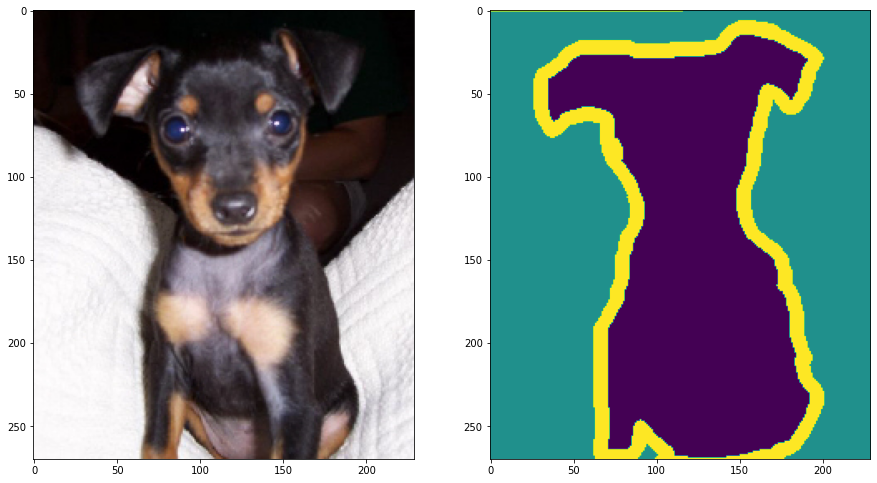

In [3]:
csv_path = 'data/kfolds.csv'
df = pd.read_csv(csv_path)
idx = random.choice(range(len(df))) # 임의로 사진 한 장 가져오기

file_name = df.loc[idx].file_name
img_path = f'data/images/{file_name}.jpg'
mask_path = f'data/annotations/trimaps/{file_name}.png'

print('img_path : ', img_path)
print('mask_path : ', mask_path)

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
print(np.unique(mask))
assert img.shape[:2] == mask.shape[:2]

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.show()

In [4]:
import albumentations as A

class Augmentation:
    def __init__(self, size, mode='train'):
        if mode == 'train':
            self.transform = A.Compose([
                # 수평
                A.HorizontalFlip(p=0.5),
                # 이동, 크기, 회전을 설정
                A.ShiftScaleRotate(
                    p=0.5,
                    shift_limit=0.05,
                    scale_limit=0.05,
                    rotate_limit=15
                ),
                # 최대 8개의 구멍을 dropout 하게됨
                A.CoarseDropout(
                    p=0.5,
                    max_holes=8,
                    max_height=int(0.1 * size),
                    max_width=int(0.1 * size)
                ),
                A.RandomBrightnessContrast(p=0.2)
            ])
    
    def __call__(self, **kwargs): # {image=image, mask=mask}
        if self.transform:
            augmented = self.transform(**kwargs)
            img = augmented['image']
            mask = augmented['mask']
            return img, mask
        
        
class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, csv_path, fold, image_size, mode='train', shuffle=True):
        self.batch_size = batch_size
        self.fold = fold
        self.image_size = image_size
        self.mode = mode
        self.shuffle = shuffle
        
        self.df = pd.read_csv(csv_path)
        
        if self.mode == 'train':
            self.df = self.df[self.df['fold'] != self.fold]
        elif self.mode == 'val':
            self.df = self.df[self.df['fold'] == self.fold]
        
        #### https://github.com/tensorflow/models/issues/3134
        #### 파일 이슈 -> 삭제
        invalid_filenames = [
            'Egyptian_Mau_14',
            'Egyptian_Mau_139',
            'Egyptian_Mau_145',
            'Egyptian_Mau_156',
            'Egyptian_Mau_167',
            'Egyptian_Mau_177',
            'Egyptian_Mau_186',
            'Egyptian_Mau_191',
            'Abyssinian_5',
            'Abyssinian_34',
            'chihuahua_121',
            'beagle_116'
        ]
        self.df = self.df[~self.df['file_name'].isin(invalid_filenames)]
        self.transform = Augmentation(image_size, mode)
        
        self.on_epoch_end()

        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
            return math.ceil(len(self.df) / self.batch_size)

    def __getitem__(self, idx):
        strt = idx * self.batch_size
        fin = (idx + 1) * self.batch_size
        data = self.df.iloc[strt:fin]
        batch_x, batch_y = self.get_data(data)
        return np.array(batch_x), np.array(batch_y)
        
    def get_data(self, data):
        batch_x = []
        batch_y = []
        
        for _, r in data.iterrows():
            file_name = r['file_name']
            image = cv2.imread(f'data/images/{file_name}.jpg')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (self.image_size, self.image_size))
            
            mask = cv2.imread(f'data/annotations/trimaps/{file_name}.png', cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (self.image_size, self.image_size))
            mask[mask != 1] = 0
            
            if self.mode == 'train':
                image, mask = self.transform(image=image, mask=mask)
            
            image = image.astype('float32')            
            image = image / 255.
            
            mask = mask.astype('float32')
        
            # label = int(r['id']) - 1
            
            batch_x.append(image)
            batch_y.append(mask)
            
        return batch_x, batch_y

    
csv_path = 'data/kfolds.csv'

train_generator = DataGenerator(
    batch_size = 128,
    csv_path = csv_path,
    fold = 1,
    image_size = 128,
    mode = 'train',
    shuffle = True
)

valid_generator = DataGenerator(
    batch_size = 128,
    csv_path = csv_path,
    fold = 1,
    image_size = 256,
    mode = 'val',
    shuffle = True
)

In [6]:
from keras_unet.models import custom_unet

model = custom_unet(
    input_shape = (128,128,3), # 데이터를 넣는 형태 설정
    use_batch_norm = True, # 정규화
    num_classes = 3,
    filters = 64,
    dropout = 0.2,
    use_attention = True,
    output_activation = 'softmax' # 여러 개의 분류를 내보냄 -> activation 함수로 'softmax'를 사용
) 

model.compile(optimizer = 'adam',loss = 'sparse_categorical_crossentropy')
model.summary()

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1728        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm

 conv2d_transpose (Conv2DTransp  (None, 16, 16, 512)  2097664    ['batch_normalization_9[0][0]']  
 ose)                                                                                             
                                                                                                  
 conv2d_10 (Conv2D)             (None, 16, 16, 512)  262656      ['batch_normalization_7[0][0]']  
                                                                                                  
 conv2d_11 (Conv2D)             (None, 16, 16, 512)  262656      ['conv2d_transpose[0][0]']       
                                                                                                  
 add (Add)                      (None, 16, 16, 512)  0           ['conv2d_10[0][0]',              
                                                                  'conv2d_11[0][0]']              
                                                                                                  
 activatio

 concatenate_2 (Concatenate)    (None, 64, 64, 256)  0           ['conv2d_transpose_2[0][0]',     
                                                                  'multiply_2[0][0]']             
                                                                                                  
 conv2d_23 (Conv2D)             (None, 64, 64, 128)  294912      ['concatenate_2[0][0]']          
                                                                                                  
 batch_normalization_14 (BatchN  (None, 64, 64, 128)  512        ['conv2d_23[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_24 (Conv2D)             (None, 64, 64, 128)  147456      ['batch_normalization_14[0][0]'] 
                                                                                                  
 batch_nor

이 부분부터 실행해보기

In [7]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    verbose=1
)

Epoch 1/20
 1/46 [..............................] - ETA: 1:15:55 - loss: 1.6992


KeyboardInterrupt



In [ ]:
import matplotlib.pyplot as plt
history = history.history
plt.figure(figsize=(15, 5))
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Loss")
plt.show()

In [ ]:
for images, mask in valid_generator:
    break
    
preds = model.predict(images)

In [ ]:
import random
idx = random.choice(range(len(preds)))

plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.imshow(images[idx, ...]) # 파라미터는 신경쓰지 않겠다.
plt.subplot(1, 3, 2)
plt.imshow(masks[idx])
plt.subplot(1, 3, 3)
pred = np.argmax(preds[idx], axis=-1)
plt.imshow(pred)

In [ ]:
np.unique(pred)